Consider the Manufacturing Email data, which is given in the following format: each row ”a b t” denotes
a contact (a temporal link) between node a and b at time step t. This contact network is sampled/measured
once every 1 second. Thus, each time step has a duration of 1s, which is though not relevant for our analysis in
this assignment. We denote this temporal network as G<sub>data</sub>.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sys

np.set_printoptions(threshold=sys.maxsize)

In [3]:
with open('manufacturing_emails_temporal_network.xlsx', 'rb') as file:
    Gdata = pd.read_excel(file)

In [4]:
print(Gdata) ##Make sure we've read the data correctly

       node1  node2  timestamp
0          1      2          1
1          1      3          1
2          1      4          1
3          1      5          1
4          1      6          1
...      ...    ...        ...
82871      3     39      57787
82872      3     39      57788
82873     18     19      57789
82874      3     85      57790
82875     85     94      57791

[82876 rows x 3 columns]


# A. Explore properties of network G that is aggregated over all the T = 57791 steps.

Specifically, the aggregated network G is composed of all the nodes that have ever appeared in the dataset and any two nodes
are connected by a link if they have at least a contact over the whole period [0,T].
Compute the following topological properties of G in 1)-7) without considering the weight of any link and
the link weight property in 8).

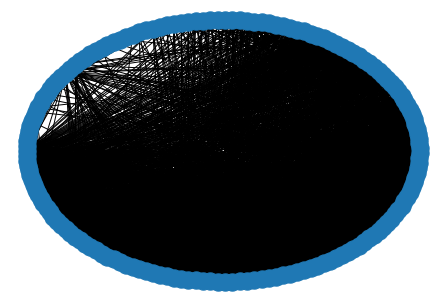

In [5]:
#We can now use networkx to help us:
#First we create the graph
aggregated_G = nx.from_pandas_edgelist(Gdata,"node1","node2")

nx.draw_shell(aggregated_G)

### 1) What is the number of nodes N, the number of links L, the average degree E[D] and standard deviation of the degree sqrt(Var[D])?

In [6]:
print("Number of Nodes:", aggregated_G.number_of_nodes())
print("Number of Links:", aggregated_G.number_of_edges())

average_deg = 0
for i in list(aggregated_G.nodes):
    average_deg += aggregated_G.degree[i]
average_deg /= aggregated_G.number_of_nodes()
print("Average degree:", average_deg)

std_deg = 0
for i in list(aggregated_G.nodes):
    std_deg += (aggregated_G.degree[i] - average_deg)**2
std_deg /= aggregated_G.number_of_nodes()
std_deg = std_deg ** 0.5
print("Standard deviation of the degree: ", std_deg)

Number of Nodes: 167
Number of Links: 3250
Average degree: 38.92215568862275
Standard deviation of the degree:  31.525295235166052


### 2) Plot the degree distribution. Which network model, Erdös-Rényi (ER) random graphs or scale-free networks, could better model this network with respect to degree distribution? Why?  

Text(0, 0.5, 'Frequency')

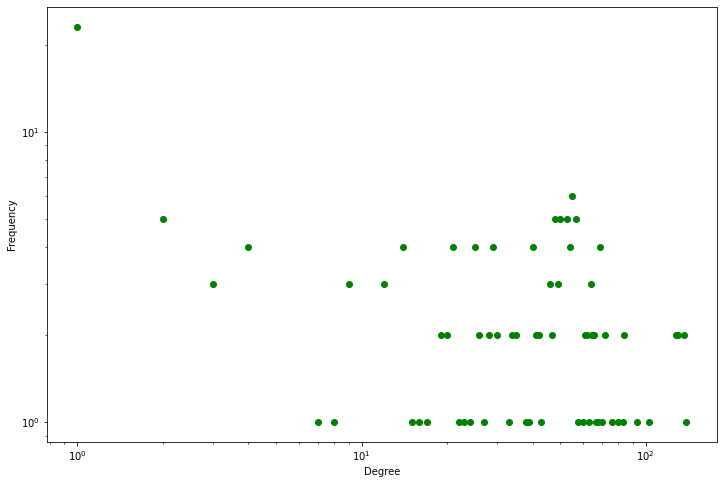

In [7]:
degree_freq = nx.degree_histogram(aggregated_G)
degrees = range(len(degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(degrees, degree_freq,'go') 
plt.xlabel('Degree')
plt.ylabel('Frequency')

### 3) What is the degree correlation (assortativity) ρ<sub>D</sub>? What is its physical meaning?

In [8]:
print("Degree correlation:", nx.degree_assortativity_coefficient(aggregated_G))

Degree correlation: -0.29517729789301855


Answer: The physical meaning is that nodes with different degrees are related

### 4) What is the clustering coefficient C?

In [9]:
print("Clustering Coefficient: ", nx.average_clustering(aggregated_G))

Clustering Coefficient:  0.5918632085486949


### 5) What is the average hopcount E[H] of the shortest paths between all node pairs? What is the diameter H<sub>max</sub>?

In [10]:
print("Average hopcount: ", nx.average_shortest_path_length(aggregated_G))
print("Diameter: ", nx.diameter(aggregated_G))

Average hopcount:  1.9673905201644903
Diameter:  5


### 6) Has this network the small-world property? Justify your conclusion quantitatively (Hint: Lecture 2).

### 7) What is the largest eigenvalue (spectral radius) λ<sub>1</sub> of the adjacency matrix?

In [12]:
L = nx.adjacency_spectrum(aggregated_G)
print("Largest eigenvalue:", max(list(L)))

Largest eigenvalue: (60.63926551053453+0j)


### 8) Consider further the weight of each link in G, which is the total number of contacts between the corresponding two nodes within [0,T]. Plot the probability density function (distribution) of the link weight (Choose the scales of the two axes and the bins/bin-size for the distribution such that the plot is insightful for interpretation). 
### The probability density function f<sub>W</sub>(x) of the weight W of a link is defined as f<sub>W</sub>(x) = lim<sub>∆x→0</sub> Pr[x<W≤x+∆x]/∆x , the probability that the variable (or the percentage of links whose weight) is within each range or bin (x,x+ ∆x] normalized by the size of the bin ∆x. Does W follow a power-law distribution? Why?

Hint: All metrics computed for the network G are recommended to put into a table.

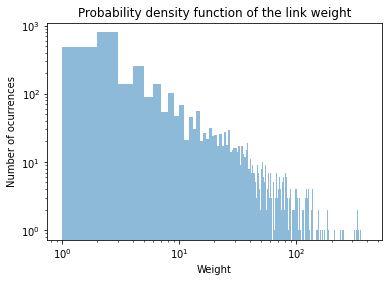

In [28]:
def calculate_weight_table(G):
    aggregated_G_timestamps = nx.from_pandas_edgelist(G,"node1","node2", create_using=nx.MultiGraph())
    weight_ocurrences = []
    G_weight_table = []
    for edge in set(aggregated_G_timestamps.edges()):
        weight_ocurrences.append(aggregated_G_timestamps.number_of_edges(edge[0],edge[1]))
        G_weight_table.append((edge,aggregated_G_timestamps.number_of_edges(edge[0],edge[1])))
    bins = np.arange(0, 400, 1) # fixed bin size
    plt.hist(weight_ocurrences, bins=bins, alpha=0.5,log=True)
    plt.xlabel("Weight")
    plt.ylabel("Number of ocurrences")
    plt.xscale('log', base=10, nonpositive='clip')    
    plt.title("Probability density function of the link weight")
    return G_weight_table
G1_weight_table = calculate_weight_table(Gdata)

# B. Information spreading on a temporal network

We consider the following information spreading process, which is actually a simplified Susceptible-Infected
model but on a temporal network. Initially, at time t = 0, a single node s is infected meaning that this
node possesses the information whereas all the other nodes are Susceptible, thus have not yet perceived the
information. Node s is also called the seed of the information. Whenever an infected node i is in contact with
a susceptible node j at any time step t, the susceptible node becomes infected during the same time step and
could possibly infect other nodes only since the next time step via its contacts with susceptible nodes. Once a
node becomes infected, it stays infected forever. For example, assume that the seed node has its first contact at
time t = 5 and that contact is with node m. Although node s gets infected since t = 0, it infects a second node,i.e. node m only at t = 5 when it contacts m. Infection happens only when an infected node and a susceptible node are in contact. The number of infected nodes is non-decreasing over time.

Simulate the information spreading process on the given temporal network Gdata for N iterations. Each
iteration starts with a different seed node infected at t = 0 and ends at t = T = 57791 the last time step that
the network is measured. Via the N iterations, we consider the spreading process that starts at every node
i ∈[1,N]. Record the number of infected nodes I(t) over time t for each iteration.

In [12]:
G_temp = nx.from_pandas_edgelist(Gdata,"node1","node2")
temporal_edge_list = Gdata.to_records(index=False)
temporal_edge_list = list(temporal_edge_list)
T = 57791
def infection(N,G,temporal_edge_list):
    
    nx.set_node_attributes(G,False,"infected")
    G.nodes[N]["infected"] = True
    infected_nodes_over_time = [0 for i in range(T)]
    infected_nodes_over_time[0] = 1
    previous_timestamp = 0
    for edge in temporal_edge_list:
        node1, node2, timestamp = edge
        if timestamp > previous_timestamp:
            newly_infected = []
        if G.nodes[node1]["infected"] and not G.nodes[node2]["infected"] and not node1 in newly_infected:
            G.nodes[node2]["infected"] = True
            infected_nodes_over_time[timestamp-1] += 1
            newly_infected.append(node2)
        elif G.nodes[node2]["infected"] and not G.nodes[node1]["infected"] and not node2 in newly_infected:
            G.nodes[node1]["infected"] = True
            infected_nodes_over_time[timestamp-1] += 1
            newly_infected.append(node1)
        previous_timestamp = timestamp
    return np.cumsum(infected_nodes_over_time)

### 9) Taking all the N iterations into count, plot the average number of infected nodes E[I(t)] together with its error bar (standard deviation sqrt(Var[I(t)]) as a function of the time step t.

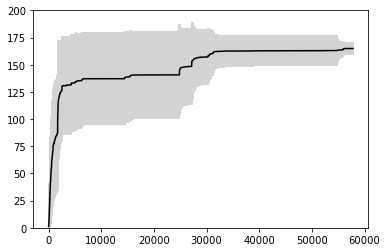

In [13]:
def ex_9(G,temporal_edge_list):
    T = 57791
    means_list = []
    variance_list = []

    total_num_infected_at_time_t = []
    for i in range(1, G.number_of_nodes()):
        total_num_infected_at_time_t.append(infection(i,G,temporal_edge_list))

    total_num_infected_at_time_t = np.asarray(total_num_infected_at_time_t)
    mean = np.mean(total_num_infected_at_time_t,axis=0)
    std = np.std(total_num_infected_at_time_t,axis=0)

    plt.errorbar(range(1,T+1),mean,yerr=std,color='black',
                 ecolor='lightgray')
    plt.ylim([0,200])
    plt.show()
    return total_num_infected_at_time_t
G1_total_num_infected_at_time_t = ex_9(G_temp,temporal_edge_list)

### 10) How influential a node is as a seed node could be partially reflected by the time it takes to reach/infect 75% of the total nodes when this node is selected as the seed node. The shorter the time is, the more influential the seed node is. Using this standard to rank the influence of all the nodes and record the ranking in a vector R = [R(1),R(2),...,R(N)] where R(i) is the node index of the i −th most influential seed node and R(1) is the most influential node that infects 75% nodes in the shortest time. Note that you don’t need to provide this vector in your report.

In [14]:
def ex_10(total_num_infected_at_time_t,G):
    array_timestamps = []
    for node in total_num_infected_at_time_t:
        index = np.argwhere(node > 0.75 * G.number_of_nodes())
        try:   
            array_timestamps.append(index[0][0])
        except:
            array_timestamps.append(T)
    indeces = np.argsort(array_timestamps)
    print(indeces+1)
    return indeces+1
G1_indeces = ex_10(G1_total_num_infected_at_time_t,G_temp)

[  1  89  88  87  86  85  84  82  81  80  79  78  77  90  76  74  73  72
  71  70  69  68  67  66  65  64  63  75  91  92  93 121 120 119 118 117
 116 115 113 112 111 110 109 108 107 106 105 104 103 102 101 100  99  98
  97  96  95  94  62  61  83  59  28  27  26  24  23  22  21  20  19  18
  17  16  15  14  13  12  11  10   9  60   8   7   6   5   4   3   2  29
  30  25  32  58  57  56  55  54  53  52  51  31  49  48  47  46  45  50
  43  44  34  35  36  37  33  39  40  41  42  38 148 136 138 139 140 141
 145 143 146 147 135 142 134 114 132 131 130 129 128 127 126 125 124 123
 122 133 137 144 149 150 151 152 153 154 156 157 158 160 161 162 159 163
 164 165 166 155]


### 11) We are going to explore which nodal level network feature in the aggregated network G could well suggest the nodal influence discussed in 10). Compute the degree and strength of each node in the aggregated network G and rank the importance of the nodes according to these two centrality metrics respectively. You obtain the ordered vector D = [D(1),D(2),...,D(N)] and S = [S(1),S(2),...,S(N)], where D(i) is the node having the i −th highest degree and S(i) is the node with the i −th highest strength. How precisely a centrality metric e.g. the degree could predict seed nodes’ influence could be quantified by the top f recognition rate rRD(f) = |Rf ∩Df ||Rf | where Rf and Df are the sets of nodes ranking in the top f fraction according to their influence and degree respectively and |Rf| = fN is the number of nodes in Rf. Plot rRD(f) and rRS(f) as a function of f where f = 0.05,0.1,0.15,...,0.5. Which metric, the degree or the strength could better predict the influence of the nodes? Why?

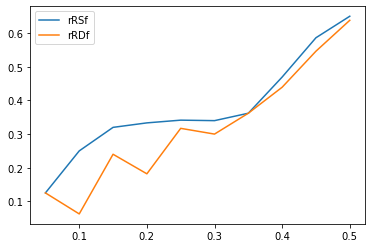

In [15]:
def ex_11(weight_table,aggregated_G,indeces):
    degrees = []
    strength = []
    for node in aggregated_G:
        degrees.append(aggregated_G.degree[node])
        node_strength = 0
        for link in weight_table:
            if link[0][0] == node or link[0][1] == node:
                node_strength += link[1]
        strength.append(node_strength)

    D = np.argsort(-np.asarray(degrees))+1 #sorted from highest degree to lowest
    S = np.argsort(-np.asarray(strength))+1
    rRDf = []
    rRSf = []
    for f in np.arange(0.05,0.55,0.05):
        sliced_D = set(D[:int(f*len(D))])
        sliced_S = set(S[:int(f*len(D))])
        sliced_R = set(indeces[:int(f*len(D))])
        rRDf.append(len(sliced_D.intersection(sliced_R))/len(sliced_R))
        rRSf.append(len(sliced_S.intersection(sliced_R))/len(sliced_R))

    plt.plot(np.arange(0.05,0.55,0.05),rRSf,label="rRSf")
    plt.plot(np.arange(0.05,0.55,0.05),rRDf,label="rRDf")
    plt.legend()
    plt.show()
    return D,S
G1_D,G1_S = ex_11(G1_weight_table,aggregated_G,G1_indeces)

### 12) Consider the third nodal property, i.e., the time Z when a node has its first contact in the network, and use this metric to predict nodes’ influence. Compare this nodal property and the two features proposed in question 11): which feature better/badly reflects how influential a node is and why? Hint: Similar to 11) plot r<sub>RZ</sub>(f) as a function of f for the feature Z

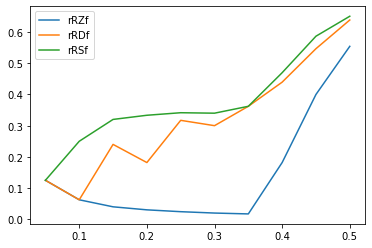

In [16]:
def ex12(total_num_infected_at_time_t,indeces,D,S):
    array_timestamps = []
    for node in total_num_infected_at_time_t:
        try:
            array_timestamps.append(np.argwhere(node > 1)[0][0])
        except:
            array_timestamps.append(T)
    Z = np.argsort(array_timestamps) + 1

    rRZf = []
    rRDf = []
    rRSf = []
    for f in np.arange(0.05,0.55,0.05):
        sliced_D = set(D[:int(f*len(D))])
        sliced_Z = set(Z[:int(f*len(D))])
        sliced_S = set(S[:int(f*len(D))])
        sliced_R = set(indeces[:int(f*len(D))])
        rRDf.append(len(sliced_D.intersection(sliced_R))/len(sliced_R))
        rRSf.append(len(sliced_S.intersection(sliced_R))/len(sliced_R))
        rRZf.append(len(sliced_Z.intersection(sliced_R))/len(sliced_R))

    plt.plot(np.arange(0.05,0.55,0.05),rRZf,label="rRZf")
    plt.plot(np.arange(0.05,0.55,0.05),rRDf,label="rRDf")
    plt.plot(np.arange(0.05,0.55,0.05),rRSf,label="rRSf")
    plt.legend()
    plt.show()
    return Z

G1_Z = ex12(G1_total_num_infected_at_time_t,G1_indeces,G1_D,G1_S)

### 13) How influential a node j is as a seed node can be also reflected by the average time E[τ(j)] = sum<sub>i∈M</sub> τi(j)/0.75N for the information starts from the seed j at t = 0 to reach the nodes that belong to the set M and the set M contains the 75% ·N nodes that are reached earliest in time by the information starts at seed j. Note that τi(j) denotes that time when node i gets infected and j is the seed node. Use this standard to rank the influence of all the nodes and record the ranking in a vector R′ = [R′(1),R′(2),...,R′(N)]. Which metric, R, the degree D, the strength S or the time of first contact Z, could better predict the influence ranking R′ ? Hint: use the method proposed in 11); Influence standard in 13) considers the average time to infect a node in M whereas the influence standard in 10) considers the time to infect all the nodes in M.

[  1   3  20  21  22  23  11  43  42  13  44   5  34  35  41   2   9  17
  14   6  12   4  15  10   8  16   7  18  19  53  52  40  51  50  57  55
  56  58  27  26  39  45  46  32  24  25  33  31  49  60  61  62  63  69
  66  54  68  67  65  64  75  77  81  48  47  70  28  29  30  71  72  73
  74  85  84  82  86  76  88  90  89  37  36  79  38  80  59  91  92  87
  96  94  83  93  97  95  98 100  99 102 101 103 106  78 110 111 108 107
 109 104 105 112 115 117 118 119 120 116 113 121 122 114 123 132 131 133
 129 130 127 126 125 124 134 136 135 128 139 141 140 145 146 147 143 148
 142 138 137 144 149 150 151 152 153 156 154 157 158 161 160 162 159 163
 164 165 166 155]


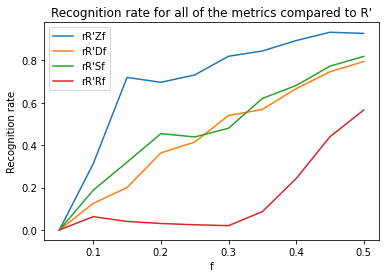

In [32]:
def ex_13(total_num_infected_at_time_t,indeces,Z,S,D):
    count_list = []
    percent = 126
    for node in total_num_infected_at_time_t:
        count = 0
        last = 0
        for timestamp in range(len(node)):
            if node[timestamp] > last:
                count += (node[timestamp] - last)*timestamp
                if node[timestamp] > percent:
                    count -= (node[timestamp] - percent)*timestamp
            last = node[timestamp]
            if node[timestamp] > percent:
                count /= percent
                break
        count_list.append(count)
    R_prime = np.argsort(count_list)
    print(R_prime+1)

    rR_primeZf = []
    rR_primeDf = []
    rR_primeSf = []
    rR_primeRf = []
    for f in np.arange(0.05,0.55,0.05):
        sliced_Z = set(Z[:int(f*len(D))])
        sliced_R = set(indeces[:int(f*len(D))])
        sliced_S = set(S[:int(f*len(D))])
        sliced_D = set(D[:int(f*len(D))])
        sliced_R_prime = set(R_prime[:int(f*len(D))])
        rR_primeZf.append(len(sliced_Z.intersection(sliced_R_prime))/len(sliced_R_prime))
        rR_primeDf.append(len(sliced_D.intersection(sliced_R_prime))/len(sliced_R_prime))
        rR_primeSf.append(len(sliced_S.intersection(sliced_R_prime))/len(sliced_R_prime))
        rR_primeRf.append(len(sliced_R.intersection(sliced_R_prime))/len(sliced_R_prime))

    plt.plot(np.arange(0.05,0.55,0.05),rR_primeZf,label="rR'Zf")
    plt.plot(np.arange(0.05,0.55,0.05),rR_primeDf,label="rR'Df")
    plt.plot(np.arange(0.05,0.55,0.05),rR_primeSf,label="rR'Sf")
    plt.plot(np.arange(0.05,0.55,0.05),rR_primeRf,label="rR'Rf")

    plt.title("Recognition rate for all of the metrics compared to R'")
    plt.xlabel("f")
    plt.ylabel("Recognition rate")
    plt.legend()
    plt.show()
ex_13(G1_total_num_infected_at_time_t,G1_indeces,G1_Z,G1_S,G1_D)

# C. Influence of temporal network features on information spreading.

### 14) Construct the following three temporal networks. G2 is exactly the same as Gdata except that the time stamps describing when each temporal link (contact) appears in Gdata are randomised in G2. In other words, G2 is constructed by copying all the temporal links {(a,b,t)} from Gdata but their time stamps t are randomly re-shuffled. The number of contacts between each node pair is the same between Gdata and G2. [A time stamp vector v, whose length equals the number of contacts, can be randomly reshuffled to a vector v2 of the same length by assigning each element in v to a randomly selected position in vector v2 while avoiding more than one elements from v assigned to the same position in v2]. G3 is constructed by the following steps: G∗3 has the same topology as G, which is an unweighted network. Secondly, G3 is obtained by assigning the set of timestamps in Gdata to the links in G∗3, randomly. A link in G∗3 may receive more than one time stamps, meaning that the two nodes contact more than once. A link in G∗3 receives no time stamp means that there is no contact between the corresponding two nodes. G3 is a temporal network composed of all these contacts and has the same number of contacts as Gdata and G2. 

Plot the probability density function (distribution) of the inter-arrival time of two consecutive contacts
between a node pair for each of these three networks Gdata, G2 and G3. Hint: For each network, collect the
inter-arrival time (time difference) between every two consecutive contacts along each node pair that has at
least two contacts and make the corresponding histogram. For a node pair that has 5 contacts, you can collect
4 inter-arrival times. How do the three networks differ from each other? Please interpret your observation.

In [18]:
G2 = Gdata.copy()
G2["timestamp"] = np.random.permutation(G2["timestamp"].values)
G2 = G2.sort_values(by=['timestamp'])

timestamps = Gdata["timestamp"].values
edges = list(nx.from_pandas_edgelist(Gdata,"node1","node2",create_using=nx.MultiGraph()).edges())

created= False
values =[]
unique_nodes = set(range(1,G_temp.number_of_nodes()))
for timestamp in timestamps:
    
    index = np.random.choice(len(edges))
    edge = edges[index]
    values = {"node1":edge[0],"node2":edge[1],"timestamp":timestamp}
    if not created :
        created= True
        dataframe = pd.DataFrame([values])
    else :
        dataframe=dataframe.append(values,ignore_index=True)
    if edge[0] in unique_nodes:
        unique_nodes.remove(edge[0])
    if edge[1] in unique_nodes:
        unique_nodes.remove(edge[1])

G3=nx.from_pandas_edgelist(dataframe,"node1","node2",create_using=nx.MultiGraph())

G1_temp=Gdata.to_records(index=False)
G1_temp=list(G1_temp)
G2_temp=G2.to_records(index=False)
G2_temp=list(G2_temp)
G3_temp=dataframe.to_records(index=False)
G3_temp=list(G3_temp)

link_timestamp_G1={}
link_timestamp_G2={}
link_timestamp_G3={}

inter_arrivals_G1=[0 for i in range(T)]
inter_arrivals_G2=[0 for i in range(T)]
inter_arrivals_G3=[0 for i in range(T)]

for G1_link in G1_temp:
    node1,node2,timestamp=G1_link
    if (node1,node2) in link_timestamp_G1.keys():
        old_timestamp=link_timestamp_G1[(node1,node2)]
        inter_arrivals_G1[timestamp-old_timestamp]+=1
        link_timestamp_G1[(node1,node2)]=timestamp
    else:
        link_timestamp_G1[(node1,node2)]=timestamp
        
for G2_link in G2_temp:
    node1,node2,timestamp=G2_link
    if (node1,node2) in link_timestamp_G2.keys():
        old_timestamp=link_timestamp_G2[(node1,node2)]
        inter_arrivals_G2[timestamp-old_timestamp]+=1
        link_timestamp_G2[(node1,node2)]=timestamp
    else:
        link_timestamp_G2[(node1,node2)]=timestamp

for G3_link in G3_temp:
    node1,node2,timestamp=G3_link
    if (node1,node2) in link_timestamp_G3.keys():
        old_timestamp=link_timestamp_G3[(node1,node2)]
        inter_arrivals_G3[timestamp-old_timestamp]+=1
        link_timestamp_G3[(node1,node2)]=timestamp
    else:
        link_timestamp_G3[(node1,node2)]=timestamp
inter_arrivals_G1[0]=0
inter_arrivals_G2[0]=0
inter_arrivals_G3[0]=0

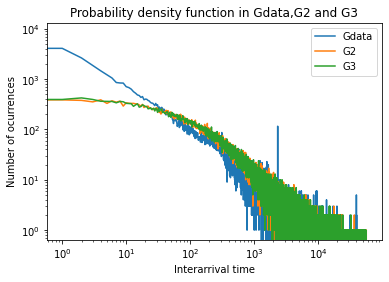

In [47]:
bins = np.arange(1,80,1) # fixed bin size
plt.loglog(inter_arrivals_G1[1:],label="Gdata")
plt.title("Probability density function in Gdata,G2 and G3")
plt.loglog(inter_arrivals_G2[1:],label="G2")
plt.loglog(inter_arrivals_G3[1:],label="G3")
plt.xlabel("Interarrival time")
plt.ylabel("Number of ocurrences")
plt.legend()
plt.show()

### 15) Simulate exactly the same information spreading process on G2 and G3 as described in B. On each temporal network, N iterations of the spreading processes are simulated and each iteration starts at a different seed node. Plot the average number of infected nodes E[I(t)] and the standard deviation sqrt(Var[I(t)]) as a function of the time step t for Gdata, G2 and G3 respectively. Compare and rank the information spreading performance (e.g. prevalence or speed of the spread) on these three temporal networks. Interpret/explain your observation. E.g. which temporal network features could possibly explain the different spreading performance?

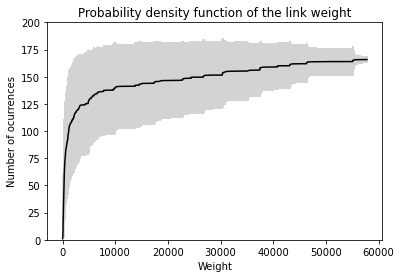

In [20]:
G2_weight_table = calculate_weight_table(G2)
G3_weight_table = calculate_weight_table(dataframe)

G2_temp = nx.from_pandas_edgelist(G2,"node1","node2")
G3_temp = nx.from_pandas_edgelist(dataframe,"node1","node2")
G3_temp.add_nodes_from(unique_nodes)

temporal_edge_list_G2 = G2.to_records(index=False)
temporal_edge_list_G2 = list(temporal_edge_list_G2)
temporal_edge_list_G3 = dataframe.to_records(index=False)
temporal_edge_list_G3 = list(temporal_edge_list_G3)

G2_total_num_infected_at_time_t = ex_9(G2_temp,temporal_edge_list_G2)

[138 126  47   1  63 103 105  24  81 113  94  52 125 133   3  57  86  71
  73  74  72  69  64  67  66  65  75  62  61  59  58  68  76  85  79 123
 121 112 109 106 104 101  98  96  95  92  90  89  88  84  82  80  77  56
  83  54  27  26  23  22  21  19  17  16  15  14  13  12  10   9   8   7
   6   5   2  29  32  20  33  53  51  50  49  48  44  43  42  41  40  39
  45  38  35  37   4 145  30  60 115  70  93 119  55 108 107  18 148 156
  78  99 149 117 128  34  36  28 139  31  11  87  25 124 129  46 134 143
 116 110 102 120 141 118 151 111  91 144 150 152 164 154 100 130 159 146
 160 140  97 137 122 142 153 166 114 135 136 127 147 132 163 131 158 155
 157 165 161 162]


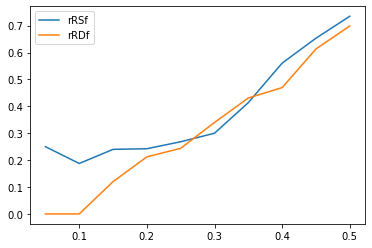

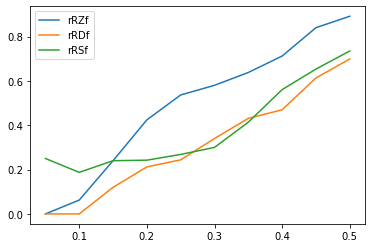

[  3  63   1  57  20  13  66  90  68  85  48  10  59  95  24  81  27  50
  45 112  15  58  54   8  44  74  98  86  94  33  22  14   5  76   2  71
  84   4  17  56  53  75 113  69  41 133  19  65   9  88  61  96  12  80
  79  40  83  16  72  35  67 104  38  32  51  47 126   6 106  21   7 105
  52 138 103 121 125 109  82  43  42  77  62  92  26 101  39  64  29  23
  49  89 123  37  30  73  70 145  60 115  93  55  18 108 107 119 139  99
  34  36 128  31  25  28 117  87  78  11 148 124 156 149  46 129 134 143
 116 110 120 102 141 118 151 111  91 144 150 152 164 154 100 130 159 146
 160 137  97 122 140 142 153 166 114 135 136 127 147 132 163 131 158 155
 157 165 161 162]


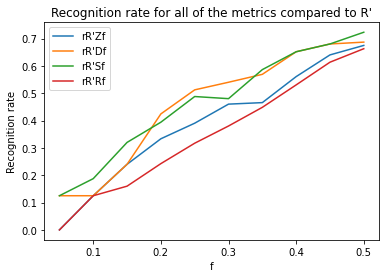

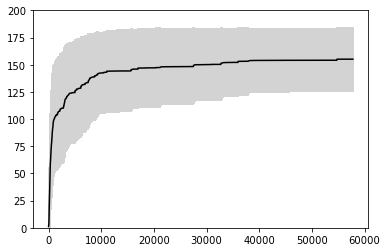

[  9  32  14  59  29  67  23  94  76  90  66  56  50  80  48  85  68   1
  88   6  15   3  17   8  54 103  12  58  96  62  63  64  65   7  69  20
  19  72  93  74  75   5  77  92   4  81  82  84   2  70  52  53  13  21
  22  24 126  26  27 117 112 130  34  35  51  38  36  44  49  40  47  42
 105  86  39  46 104  89 128 146 144  95 111 106 108  98 119  83  55  43
  61  71  18  73 145  91  31  11  57  99 113 101  30 107 123 115  45 110
  28  79  33  10  16  37  87 150 143  25 120 124 139 102 142 116 109 138
 134 133  60 151  41 121 149  97 100 141 159 122 140 132 162 148 160 118
 147  78 129 152 131 127 161 136 165 114 125 163 137 153 164 155 154 156
 157 158 135 166]


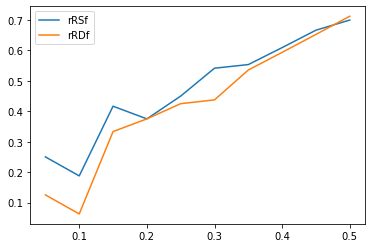

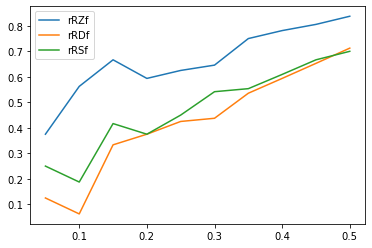

[166 158 157 156 154 135  29  68  50  94  67  90   9   3   8   1  14  86
  59  76  56  15  74  69  93  48  88  17   2  47   6  42  80  66  82  13
   5  12  26  84  21  34  52   7  35  20  65  92 112  32  23  85   4  63
  58  27  75  53  70  19  40  51  24  39  54  44 103 130  81  62  77 105
  96  72  49 117  22  18 111  98  73  71 108  55 104  64  89 119  61  38
  36  95  43 128  57 101  99 107  30  46 126  83 145  11  31 106 113  45
 146 123 144  33  91 110  79  28 115  10 150  16  37  87 143 120  25 124
 142 139 102 121 134  41 109 116 151  60 133 149 138  97 100 141 159 140
 122 132 162 148 160 118 147  78 129 152 131 127 161 136 165 114 125 163
 137 153 164 155]


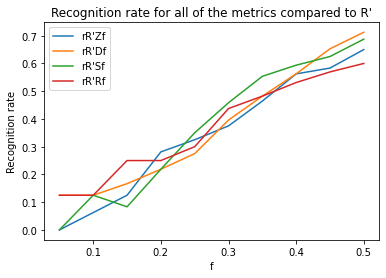

In [36]:
G2_indeces = ex_10(G2_total_num_infected_at_time_t,G2_temp)
aggregated_G2 = nx.from_pandas_edgelist(G2,"node1","node2")
G2_D,G2_S = ex_11(G2_weight_table,aggregated_G2,G2_indeces)
G2_Z = ex12(G2_total_num_infected_at_time_t,G2_indeces,G2_D,G2_S)
ex_13(G2_total_num_infected_at_time_t,G2_indeces,G2_Z,G2_S,G2_D)


G3_total_num_infected_at_time_t = ex_9(G3_temp,temporal_edge_list_G3)
G3_indeces = ex_10(G3_total_num_infected_at_time_t,G3_temp)
aggregated_G3 = nx.from_pandas_edgelist(dataframe,"node1","node2")
G3_D,G3_S = ex_11(G3_weight_table,aggregated_G3,G3_indeces)
G3_Z = ex12(G3_total_num_infected_at_time_t,G3_indeces,G3_D,G3_S)
ex_13(G3_total_num_infected_at_time_t,G3_indeces,G3_Z,G3_S,G3_D)